In [2]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
sys.path.append('/home/massoale/Bureau/Stage_M2/stage_diags/diagnostics_pkg/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import scipy as sp
import io_utils as io
from diagnostics_pkg import operators as op

la simulation chargée est: dahu_48
depuis: dahu
dict_keys(['time', 'y', 'x', 'level', 'psi', 'q'])
{'NX': 512.0, 'NY': 512.0, 'nl': 1.0, 'Lx': 6.283185307179586, 'f0': 2.0, 'beta': 7.0, 'k_f': 32.0, 'sigma_f': 0.002, 'bc_fac': -1.0, 'dh': array([1.]), 'N2': array([0.]), 'nu': 0.0, 'nu_hyper': 9e-15, 'n_hyper': 6.0, 'hEkb': 0.0005, 'tend': 1576800000000.0, 'dt_out': 10.0}


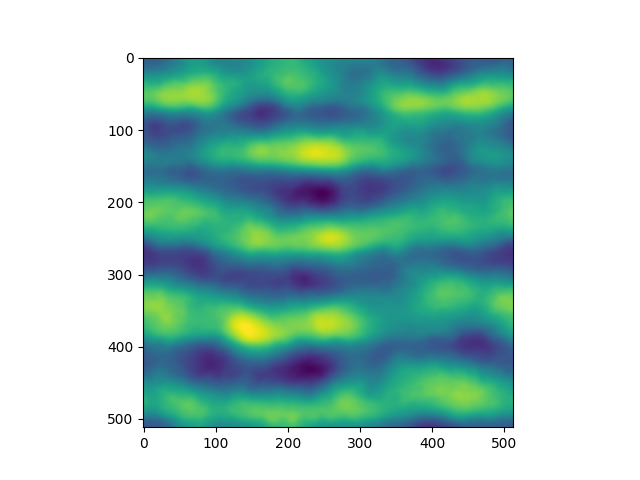

In [4]:
#Number of simulation
n=48

#choose between 'local' or 'dahu'
where='dahu'


#Reading the netcdf file
if where=='local':
    if n<10:
        simu_name='outdir_000'+str(n)
    elif n<100 and n>=10:
        simu_name='outdir_00'+str(n)
    Path='/home/massoale/Simu_Test/qgw-main/src/'+simu_name+'/'

elif where=='dahu':
    simu_name='dahu_'+str(n)
    Path='/home/massoale/Simu_Test/simu_dahu/simu_dahu'+str(n)+'/outdir_0001/'

else:
    print('Error: where not recognized')
    sys.exit()
print('la simulation chargée est: ' + simu_name )
print("depuis: "+where)

filenames=['/vars.nc']



dataset=nc.Dataset(Path+filenames[0])
#dataset=nc.Dataset('./wave_simu_stocka0.nc/outdir_0001/vars.nc')


print(dataset.variables.keys())

t=dataset.variables['time'][:]
x=dataset.variables['x'][:]
y=dataset.variables['y'][:]
psi=dataset.variables['psi'][:,0,:,:]
q=dataset.variables['q'][:,0,:,:]



param=io.read_params(Path)
print(param)
f0= param['f0']
beta=param['beta']
hEkb=param['hEkb']
dh=param['dh'][0]
Lx=param['Lx']
nx=param['NX']
ny=param['NY']
k_f=param['k_f']
sigma_f=param['sigma_f']
bc_fac=param['bc_fac']
nu_hyper=param['nu_hyper']
n_hyper=param['n_hyper']
dt_out=param['dt_out']


plt.figure()
plt.imshow(psi[-2,:,:])

# Functions for fourier end energy computation

In [5]:
def fft2d_RI(psi, Lx, nx, ny,time_sel=1):
    
    dx = Lx / nx
    dy = Lx / ny

    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    ky = np.fft.fftfreq(ny, d=dy) * 2 * np.pi  
    
    kx_shifted = np.fft.fftshift(kx)
    ky_shifted = np.fft.fftshift(ky)
    
    Kx, Ky = np.meshgrid(kx_shifted, ky_shifted)
    #Ky = np.flipud(Ky)

    
    psi_data = psi[time_sel, :, :]

    # 2D Fourier Transform
    fft_result = np.fft.fft2(psi_data) / (nx * ny) 
    fft_shifted = np.fft.fftshift(fft_result)  # Shift zero frequency component to center

    return fft_shifted, Kx, Ky



In [6]:
def energy_fourier(fft,Kx,Ky):
    print(np.shape(fft),np.shape(Kx),np.shape(Ky))
    k_norm=np.sqrt(Kx**2+Ky**2)
    Energy_density=np.abs(fft)**2*k_norm**2
    
    return Energy_density




In [52]:
# #Computing non linear energy term


# def non_linear_energy(fft,Kx,Ky):
#     NL_energy=np.zeros_like(fft)
#     for i0,l0 in enumerate(Ky[:,0]):
#         for j0,k0 in enumerate(Kx[0,:]):
#             # Find the index of the closest value to k in kx_shifted
#             k0_index = np.argmin(np.abs(k0 - Kx[0,:]))

#             # Find the index of the closest value to l in ky_shifted
#             l0_index = np.argmin(np.abs(l0 - Ky[:,0]))
            
#             for i,l in enumerate(Ky[:,0]):
#                 for j,k in enumerate(Kx[0,:]):
#                     # Find the index of the closest value to k in kx_shifted
#                     k_index = np.argmin(np.abs(k - Kx[0,:]))

#                     # Find the index of the closest value to l in ky_shifted
#                     l_index = np.argmin(np.abs(l - Ky[:,0]))

#                     kminusk0_index = np.argmin(np.abs(k0 - k - Kx[0,:]))
#                     lminusl0_index = np.argmin(np.abs(l0 - l - Ky[:,0]))

#                     kplusk0_index = np.argmin(np.abs(k0 + k - Kx[0,:]))
#                     lplusl0_index = np.argmin(np.abs(l0 + l - Ky[:,0]))

#                     NL_energy[i0,j0]+=1/4*(k*l0-l*k0) * (\
#                                     np.sqrt((k0-k)**2+(l0-l)**2)*( fft[l_index,k_index]*fft[lminusl0_index,kminusk0_index]*np.conj(fft[l0_index,k0_index])\
#                                                                    + np.conj(fft[l_index,k_index])*fft[lminusl0_index,kminusk0_index]*fft[l0_index,k0_index] )\
#                                     -  np.sqrt((k0+k)**2+(l0+l)**2)*( np.conj(fft[l_index,k_index])*fft[lplusl0_index,kplusk0_index]*np.conj(fft[l0_index,k0_index])\
#                                                                     + fft[l_index,k_index]*fft[lplusl0_index,kplusk0_index]*fft[l0_index,k0_index] )\
#                                     )
#         print(i0,"/",len(Ky[:,0]))
#     return fft



In [53]:
def fft_kpluk0(fft,k,l,bool_plus=True,L=Lx):
    """
    fft: FFT de psi
    k,l: Wavenumbers to shift (k0+k,l0+l)

    Calcul psi(K+K0) en vectorisant. 
    Retourne une matrice de même taille que fft avec les valeurs de psi(K+K0) shiftées
    
    Si Bool_plus=false calcule psi(K-K0) shiftée
    """

        
    New_fft_shift=np.zeros_like(fft)

    #Pour le calcul de FFT de (k-k0,l-l0)
    if bool_plus == False:
        k=-k
        l=-l

    m=int(np.round(L*k/(2*np.pi)))
    n=int(np.round(L*l/(2*np.pi)))
    
    
    if k >= 0 and l >= 0:

        if n==0 and m!=0:
            Mat_fft_cut=fft[:,m:]
            New_fft_shift[:,:-m]=Mat_fft_cut

        elif n!=0 and m==0:
            Mat_fft_cut=fft[n:,:]
            New_fft_shift[:-n,:]=Mat_fft_cut

        elif n==0 and m==0:
            Mat_fft_cut=fft[:,:]
            New_fft_shift[:,:]=Mat_fft_cut

        else:
            Mat_fft_cut=fft[n:,m:]
            New_fft_shift[:-n,:-m]=Mat_fft_cut

    elif k < 0 and l < 0:

        if n==0 and m!=0:
            Mat_fft_cut=fft[:,:m]
            New_fft_shift[:,-m:]=Mat_fft_cut

        elif n!=0 and m==0:
            Mat_fft_cut=fft[:n,:]
            New_fft_shift[-n:,:]=Mat_fft_cut

        elif n==0 and m==0:
            Mat_fft_cut=fft[:,:]
            New_fft_shift[:,:]=Mat_fft_cut

        else:
            Mat_fft_cut=fft[:n,:m]
            New_fft_shift[-n:,-m:]=Mat_fft_cut

    elif k >= 0 and l < 0:

        if n==0 and m!=0:
            Mat_fft_cut=fft[:,m:]
            New_fft_shift[:,:-m]=Mat_fft_cut

        elif n!=0 and m==0:
            Mat_fft_cut=fft[:n,:]
            New_fft_shift[-n:,:]=Mat_fft_cut

        elif n==0 and m==0:
            Mat_fft_cut=fft[:,:]
            New_fft_shift[:,:]=Mat_fft_cut

        else:
            Mat_fft_cut=fft[:n,m:]
            New_fft_shift[-n:,:-m]=Mat_fft_cut

    elif k < 0 and l >= 0:


        if n==0 and m!=0:
            Mat_fft_cut=fft[:,:m]
            New_fft_shift[:,-m:]=Mat_fft_cut

        elif n!=0 and m==0:
            Mat_fft_cut=fft[n:,:]
            New_fft_shift[:-n,:]=Mat_fft_cut

        elif n==0 and m==0:
            Mat_fft_cut=fft[:,:]
            New_fft_shift[:,:]=Mat_fft_cut

        else:
            Mat_fft_cut=fft[n:,:m]
            New_fft_shift[:-n,-m:]=Mat_fft_cut

    return New_fft_shift


In [54]:
#Computing non linear energy, with vectorisation

def non_linear_energy_vect(fft,Kx,Ky,L=Lx):
    """
    fft: 2D array of the fft of psi
    Kx,Ky: 2D arrays of the wavenumbers

    return the non linear energy term in the Fourier space
    """

    NL_energy=np.zeros_like(fft)

    for i,l in enumerate(Ky[:,0]):
        for j,k in enumerate(Kx[0,:]):
            #Finding the indices of k,l
            m=int(np.round(L*k/(2*np.pi)))+len(Kx[0,:])//2
            n=int(np.round(L*l/(2*np.pi)))+len(Ky[:,0])//2


            NL_energy += 1/4*(k*Ky-l*Kx) * (\
                            ((k-Kx)**2+(l-Ky)**2)*( fft[n,m]*fft_kpluk0(fft,k,l,False,L)*np.conj(fft)\
                                                               + np.conj(fft[n,m])*np.conj(fft_kpluk0(fft,k,l,False,L))*fft )\
                            -  ((Kx+k)**2+(Ky+l)**2)*( np.conj(fft[n,m])*fft_kpluk0(fft,k,l,True,L)*np.conj(fft)\
                                                            + fft[n,m]*np.conj(fft_kpluk0(fft,k,l,True,L))*fft )\
                            )
        print(f"Processing row {i+1}/{len(Ky[:, 0])}")

    return NL_energy




In [55]:

from joblib import Parallel, delayed



def parallel_non_linear_energy(ffts, Kx, Ky, L=Lx, n_jobs=-1):
    """
    ffts: List of 2D arrays of the fft of psi over time
    Kx, Ky: 2D arrays of the wavenumbers
    L: Length scale
    n_jobs: Number of jobs for parallel processing

    Returns a list of non-linear energy terms for each time snapshot
    """
    results = Parallel(n_jobs=n_jobs)(
        delayed(non_linear_energy_vect)(fft, Kx, Ky, L) for fft in ffts
    )
    return results


nx = int(nx)
ny = int(ny)
time_idx=np.arange(0,15,1)
ffts = [fft2d_RI(psi, Lx, nx, ny, time_sel=i)[0] for i in time_idx]
Kx,Ky = fft2d_RI(psi, Lx, nx, ny, time_sel=0)[1:3]
#non_linear_energies = parallel_non_linear_energy(ffts, Kx, Ky, Lx)



(15, 512, 512) (512, 512) (512, 512)


/tmp/ipykernel_190661/5496742.py:8: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(Kx,Ky,np.log(mean_energy_dens))


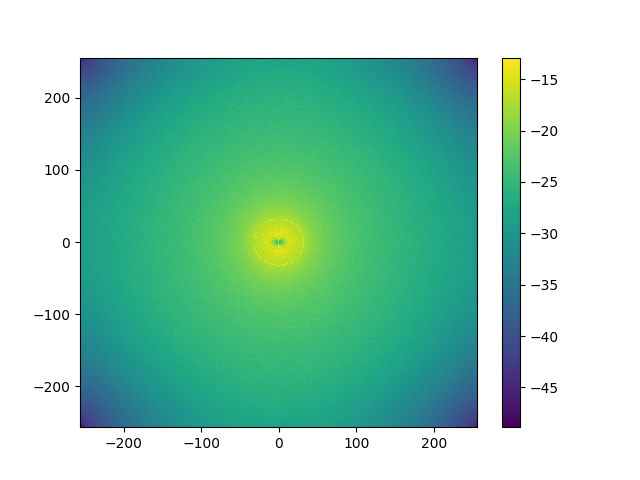

In [56]:
nx = int(nx)
ny = int(ny)


mean_energy_dens=np.mean(energy_fourier(ffts,Kx,Ky),axis=0)

plt.figure()
plt.pcolormesh(Kx,Ky,np.log(mean_energy_dens))
plt.colorbar()
plt.show()

/tmp/ipykernel_190661/145508836.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(14, 6))
/tmp/ipykernel_190661/145508836.py:20: RuntimeWarning: divide by zero encountered in log
  c1 = axs[0].pcolormesh(Kx, Ky, np.log(dissipated_energy_r), shading='auto',vmin=-40,vmax=-10)#,vmin=np.log(scale_min),vmax=np.log(scale_max)/100)
/tmp/ipykernel_190661/145508836.py:27: RuntimeWarning: divide by zero encountered in log
  c2 = axs[1].pcolormesh(Kx, Ky, np.log(np.abs(dissipated_energy_nu)), shading='auto',vmin=-40,vmax=-10)#,vmin=np.log(scale_min),vmax=np.log(scale_max)/100)


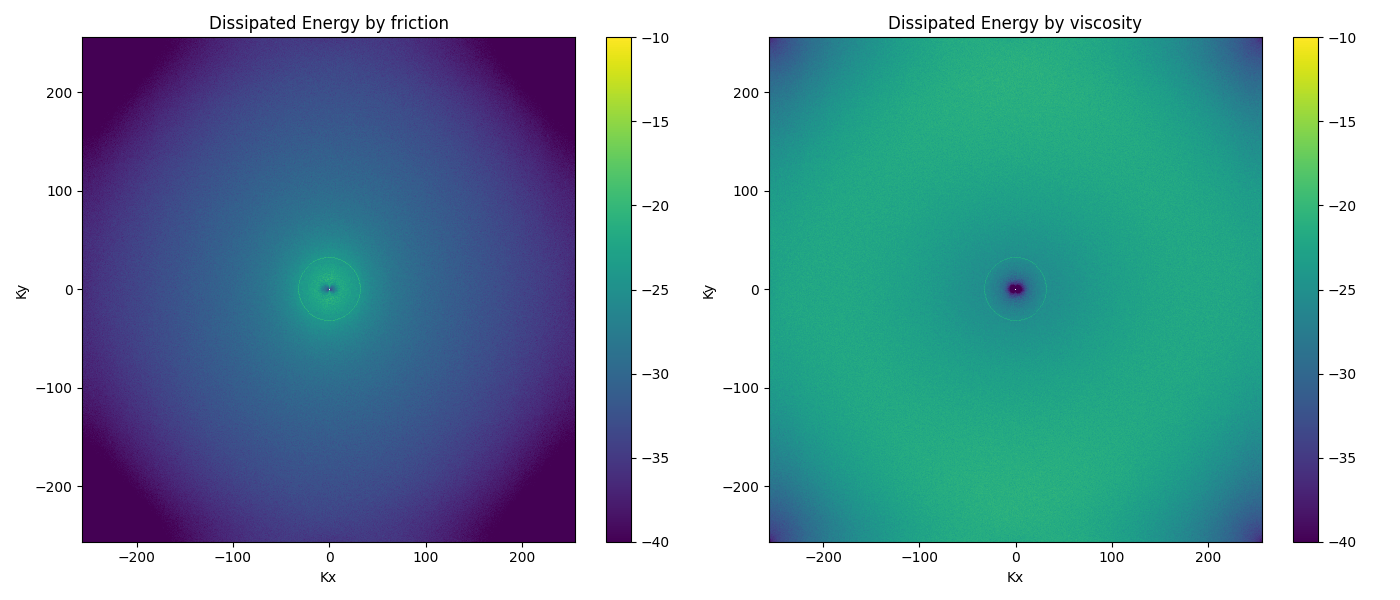

In [57]:
#
r=f0*hEkb/(2*dh)
k_norm=np.sqrt(Kx**2+Ky**2)
dx = Lx / nx
dy = Lx / ny


dissipated_energy_r=2*r*mean_energy_dens

dissipated_energy_nu=nu_hyper*mean_energy_dens*k_norm**(n_hyper+1)


scale_min=np.min([np.min(dissipated_energy_r),np.min(dissipated_energy_nu)])
scale_max=np.max([np.max(dissipated_energy_r),np.max(dissipated_energy_nu)])

#Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot dissipated_energy_r
c1 = axs[0].pcolormesh(Kx, Ky, np.log(dissipated_energy_r), shading='auto',vmin=-40,vmax=-10)#,vmin=np.log(scale_min),vmax=np.log(scale_max)/100)
fig.colorbar(c1, ax=axs[0])
axs[0].set_title('Dissipated Energy by friction')
axs[0].set_xlabel('Kx')
axs[0].set_ylabel('Ky')

# Plot dissipated_energy_nu
c2 = axs[1].pcolormesh(Kx, Ky, np.log(np.abs(dissipated_energy_nu)), shading='auto',vmin=-40,vmax=-10)#,vmin=np.log(scale_min),vmax=np.log(scale_max)/100)
fig.colorbar(c2, ax=axs[1])
axs[1].set_title('Dissipated Energy by viscosity')
axs[1].set_xlabel('Kx')
axs[1].set_ylabel('Ky')

# Show the plot
plt.tight_layout()
plt.savefig("figures/Energy_diags/Dissipated_energy"+simu_name+".png")
plt.show()

In [58]:

# dx = Lx / nx
# dy = Lx / ny
# kx = np.fft.fftfreq(int(nx), d=dx) * 2 * np.pi
# ky = np.fft.fftfreq(int(ny), d=dy) * 2 * np.pi  

# kx_shifted = np.fft.fftshift(kx)
# ky_shifted = np.fft.fftshift(ky)
# #print(ky_shifted)

# #Ici on déplace le kx de 10 et le ky de 20
# k=kx_shifted[256+10]
# l=ky_shifted[256+10]
# print("k",k,"l",l) 


# bool_plus=True

# New_fft_shift=np.zeros_like(fft)


# #On calcul le nouveau FFT shifted de k+k0

# #Pour le calcul de FFT de (k-k0,l-l0)
# if bool_plus == False:
#     k=-k
#     l=-l

# m=int(np.round(Lx*k/(2*np.pi)))
# n=int(np.round(Lx*l/(2*np.pi)))
# n_shift=n
# print("shifting de ",n_shift)                             #Computing the distance to shift
# print("Bool_plus",bool_plus)
# if k >= 0 and l >= 0:

#     print("m,n",m,n)


#     #Calculating the fft(k+k0,l+l0)

#     if n==0 and m!=0:
#         Mat_fft_cut=fft[:,m:]
#         New_fft_shift[:,:-m]=Mat_fft_cut

#     elif n!=0 and m==0:
#         Mat_fft_cut=fft[n:,:]
#         New_fft_shift[:-n,:]=Mat_fft_cut

#     elif n==0 and m==0:
#         Mat_fft_cut=fft[:,:]
#         New_fft_shift[:,:]=Mat_fft_cut

#     else:
#         Mat_fft_cut=fft[n:,m:]
#         New_fft_shift[:-n,:-m]=Mat_fft_cut

# elif k < 0 and l < 0:

#     print("m,n",m,n)
    
#     print(np.shape(Mat_fft_cut),np.shape(New_fft_shift))
#     if n==0 and m!=0:
#         Mat_fft_cut=fft[:,:m]
#         New_fft_shift[:,-m:]=Mat_fft_cut

#     elif n!=0 and m==0:
#         Mat_fft_cut=fft[:n,:]
#         New_fft_shift[-n:,:]=Mat_fft_cut

#     elif n==0 and m==0:
#         Mat_fft_cut=fft[:,:]
#         New_fft_shift[:,:]=Mat_fft_cut

#     else:
#         Mat_fft_cut=fft[:n,:m]
#         New_fft_shift[-n:,-m:]=Mat_fft_cut

# elif k >= 0 and l < 0:

  

#     print("m,n",m,n)
#     print(np.shape(Mat_fft_cut),np.shape(New_fft_shift))
#     if n==0 and m!=0:
#         Mat_fft_cut=fft[:,m:]
#         New_fft_shift[:,:-m]=Mat_fft_cut

#     elif n!=0 and m==0:
#         Mat_fft_cut=fft[:n,:]
#         New_fft_shift[-n:,:]=Mat_fft_cut

#     elif n==0 and m==0:
#         Mat_fft_cut=fft[:,:]
#         New_fft_shift[:,:]=Mat_fft_cut

#     else:
#         Mat_fft_cut=fft[:n,m:]
#         New_fft_shift[-n:,:-m]=Mat_fft_cut

# elif k < 0 and l >= 0:

#     #Calculating the fft(k+k0,l+l0)

#     print("m,n",m,n)
#     print(np.shape(Mat_fft_cut),np.shape(New_fft_shift))
#     if n==0 and m!=0:
#         Mat_fft_cut=fft[:,:m]
#         New_fft_shift[:,-m:]=Mat_fft_cut

#     elif n!=0 and m==0:
#         Mat_fft_cut=fft[n:,:]
#         New_fft_shift[:-n,:]=Mat_fft_cut

#     elif n==0 and m==0:
#         Mat_fft_cut=fft[:,:]
#         New_fft_shift[:,:]=Mat_fft_cut

#     else:
#         Mat_fft_cut=fft[n:,:m]
#         New_fft_shift[:-n,-m:]=Mat_fft_cut




# print(np.shape(Mat_fft_cut),np.shape(New_fft_shift))
# plt.figure(figsize=(15,7.5))
# plt.subplot(1,2,1)
# plt.pcolormesh(Kx, Ky,np.log(np.abs(fft)))
# plt.subplot(1,2,2)
# plt.pcolormesh(Kx, Ky,np.log(np.abs(New_fft_shift)))

# plt.show()
# print("Ky[0,0]",Ky[0,0],"Ky[1,0]",Ky[1,0])

In [59]:
#non_lin_term=non_linear_energy_vect(fft,Kx,Ky)
#np.save('non_linear_energy_matrix/non_lin_term.npy', non_lin_term)
non_lin_term=np.load('non_linear_energy_matrix/non_lin_term.npy')
print(np.shape(non_lin_term))
print(np.sum(non_lin_term))

(512, 512)
(-6.447416716408536e-17+0j)


/tmp/ipykernel_190661/1067223416.py:2: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(Kx,Ky,np.log(np.abs(non_lin_term)))


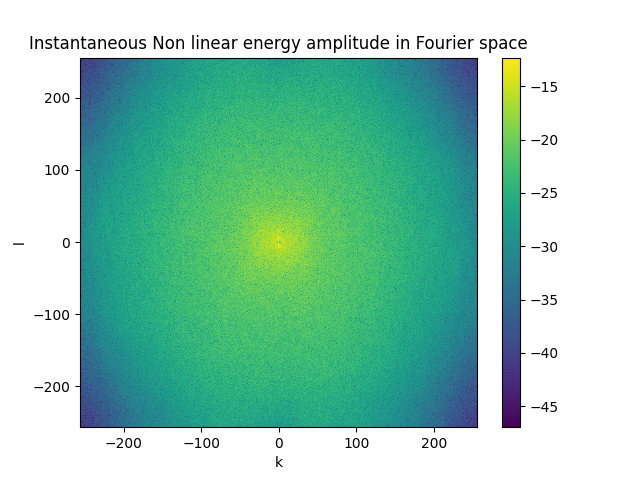

In [60]:
plt.figure()
plt.pcolormesh(Kx,Ky,np.log(np.abs(non_lin_term)))
plt.colorbar()
plt.xlabel('k')
plt.ylabel('l')
plt.title('Instantaneous Non linear energy amplitude in Fourier space')
plt.savefig("figures/Energy_diags/Non_linear_energ_y"+simu_name+".png") 
plt.show()


## Averaging Non linear energy over several snapshots

In [61]:
#np.save('non_linear_energy_matrix/non_lin_term_list.npy', non_linear_energies)
non_linear_energy_list=np.load('non_linear_energy_matrix/non_lin_term_list.npy')
print(np.shape(non_linear_energy_list))

(8, 512, 512)


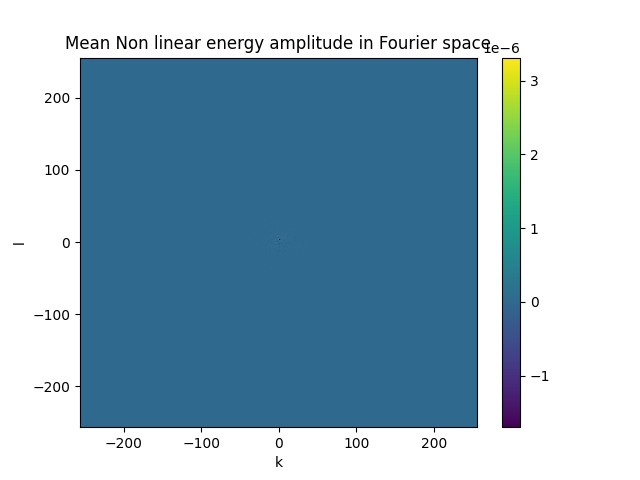

(-2.769218711092775e-19+0j)


In [69]:
mean_non_linear_energy=np.mean(non_linear_energy_list,axis=0)

plt.figure()
plt.pcolormesh(Kx,Ky,np.real(mean_non_linear_energy))
plt.colorbar()
plt.xlabel('k')
plt.ylabel('l')
plt.title('Mean Non linear energy amplitude in Fourier space')
plt.savefig("figures/Energy_diags/Mean_Non_linear_energ_y"+simu_name+".png")
plt.show()

print(np.sum(mean_non_linear_energy))


/tmp/ipykernel_190661/2774545393.py:6: RuntimeWarning: divide by zero encountered in log
  plt.pcolormesh(Kx,Ky,np.log(np.abs(Sum_energy)))


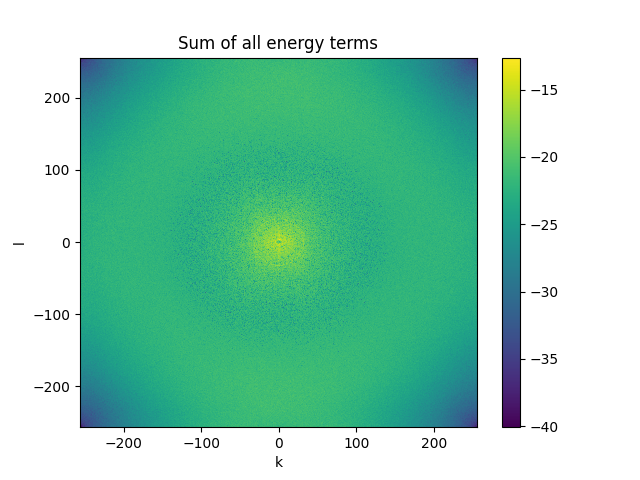

0.00017809313196641663


In [63]:
#Checking if we did correct computaions

Sum_energy=dissipated_energy_r+dissipated_energy_nu+mean_non_linear_energy

plt.figure()
plt.pcolormesh(Kx,Ky,np.log(np.abs(Sum_energy)))
plt.colorbar()
plt.xlabel('k')
plt.ylabel('l')
plt.title('Sum of all energy terms')
plt.savefig("figures/Energy_diags/Sum_energy_terms_y"+simu_name+".png")
plt.show()

print(np.sum(np.abs(Sum_energy)))


# Diags for One value of k0 and l0

k0= 0.0 l0 -0.8375
k0 0.0 l0 -0.8375
(118, 2048, 2048)


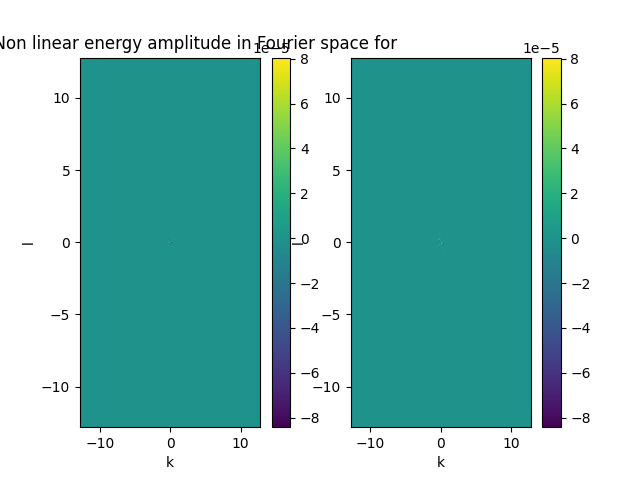

0.5240853337376076
est ce que c'est 0?? 3.74975850123731e-12


In [18]:
simu_nam='619'
nx,ny=2048,2048
Lx=502.65482457
kx=np.fft.fftfreq(nx,d=Lx/nx)*2*np.pi
ky=np.fft.fftfreq(ny,d=Lx/ny)*2*np.pi
kx_shift=np.fft.fftshift(kx)
ky_shift=np.fft.fftshift(ky)
Kx,Ky=np.meshgrid(kx_shift,ky_shift)
mode_file=np.load('/home/massoale/Bureau/Stage_M2/figures/Wave_sign/modes_jetdahu_620.npy')
k0=mode_file[1,0]
l0=mode_file[1,1]   
print("k0=",k0,"l0",l0)
print("k0",k0,"l0",l0)
#non_linear_energy_k0_l0=np.load('non_linear_energy_matrix/non_lin_term_list0.0125_-0.3875.npy')
non_linear_energy_list=np.load('../non_linear_energy_matrix/non_lin_term_jet_list.npy')
non_linear_energy_mode=np.load('../non_linear_energy_matrix/non_lin_term_jet_-0.8375.npy')
print(np.shape(non_linear_energy_list))
#mean_non_linear_energy_k0_l0=np.mean(non_linear_energy_k0_l0,axis=0)
#print(np.shape(mean_non_linear_energy_k0_l0))
sum=np.sum(non_linear_energy_list,axis=0)




plt.figure()
plt.subplot(1,2,1)
#.pcolormesh(Kx,Ky,np.real(non_linear_energy_list[0]))
plt.pcolormesh(Kx,Ky,np.real(non_linear_energy_list[1]))
plt.colorbar()
plt.xlabel('k')
plt.ylabel('l')
plt.title('Mean Non linear energy amplitude in Fourier space for')
#plt.savefig("figures/Energy_diags/Mean_Non_linear_energ"+simu_nam+".png")
plt.subplot(1,2,2)
plt.pcolormesh(Kx,Ky,np.real(np.mean(non_linear_energy_mode,axis=0)))
plt.colorbar()
plt.xlabel('k')
plt.ylabel('l')
#plt.title('Mean Non linear energy amplitude in Fourier space for')

plt.show()
plt.savefig("figures/Energy_diags/Non_linear_energ_compa"+simu_nam+".png")


print(np.sum(sum))
print("est ce que c'est 0??",np.max(np.real(non_linear_energy_list[1])-np.real(np.mean(non_linear_energy_mode,axis=0))))


In [ ]:


# Example Kx matrix
Kx = np.array([[0, 1, 2], 
               [3, 4, 5], 
               [6, 7, 8]])

# Example k value
k = 1

# Find where Kx - k is equal to values in Kx
difference_matrix = Kx - k
matching_indices = np.argwhere(np.isin(Kx,Kx-k))

print("Kx:")
print(Kx)
print("Difference matrix (Kx - k):")
print(difference_matrix)
print("Matching indices (where Kx  is in Kx-k):")
print(matching_indices)


Kx:
[[0 1 2]
 [3 4 5]
 [6 7 8]]
Difference matrix (Kx - k):
[[-1  0  1]
 [ 2  3  4]
 [ 5  6  7]]
Matching indices (where Kx  is in Kx-k):
[[0 0]
 [0 1]
 [0 2]
 [1 0]
 [1 1]
 [1 2]
 [2 0]
 [2 1]]


# Test Case

In [ ]:
#Test of two waves interaction

# create three waves

N = 64
L = 1

#wave parameters
n1, m1 = -1,2
n2, m2 = 2,1

k1 = 2*np.pi*n1/L
l1 = 2*np.pi*m1/L
k2 = 2*np.pi*n2/L
l2 = 2*np.pi*m2/L

A1 = 1.4
A2 = 2.2

theta1 = 3.5
theta2 = 1.2


# third wave
n3 = n1+n2
m3 = m1+m2

k3 = 2*np.pi*n3/L
l3 = 2*np.pi*m3/L



A3 = 0.7
theta3 = 0.12

#grid
dx = L/N

x = np.linspace(dx/2, L - dx/2, N)
y = np.linspace(dx/2, L - dx/2, N)

X, Y = np.meshgrid(x,y)

# create waves

waves = A1*np.sin(k1*X + l1*Y + theta1) + A2*np.sin(k2*X + l2*Y + theta2) + A3*np.sin(k3*X + l3*Y + theta3)
print(k1,k2,k3)


-6.283185307179586 12.566370614359172 6.283185307179586


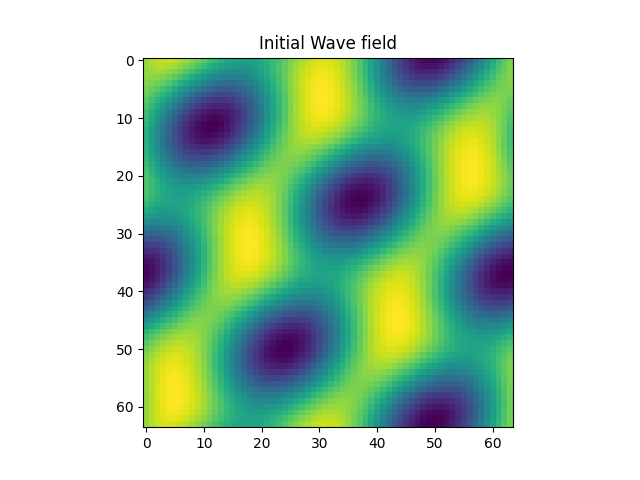

In [ ]:
plt.figure()
plt.imshow(waves)
plt.title("Initial Wave field")

plt.show()

In [ ]:
psi=np.zeros((1,N,N))
psi[0,:,:]=waves

fft,Kx,Ky=fft2d_RI(psi,L,N,N,0)

dx = L / N
dy = L / N

energy_dens=energy_fourier(fft,Kx,Ky)
print(len(Ky[:,0])//2)


(64, 64) (64, 64) (64, 64)
32


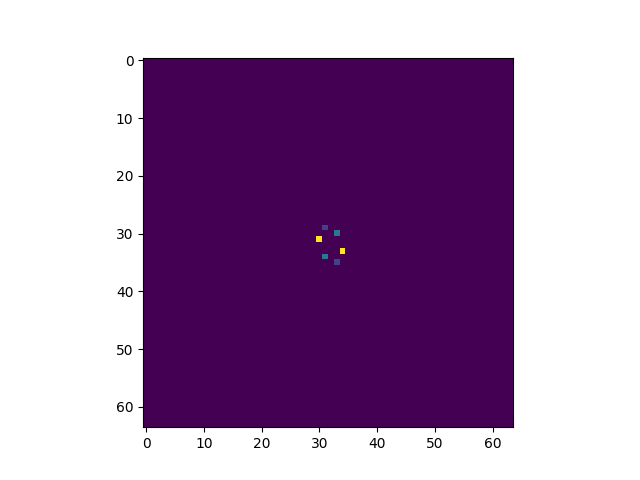

In [ ]:
plt.figure()
plt.imshow(np.abs(energy_dens))
plt.show()

In [ ]:
non_linear_energy=non_linear_energy_vect(fft,Kx,Ky,L)


0 / 64
1 / 64
2 / 64
3 / 64
4 / 64
5 / 64
6 / 64
7 / 64
8 / 64
9 / 64
10 / 64
11 / 64
12 / 64
13 / 64
14 / 64
15 / 64
16 / 64
17 / 64
18 / 64
19 / 64
20 / 64
21 / 64
22 / 64
23 / 64
24 / 64
25 / 64
26 / 64
27 / 64
28 / 64
29 / 64
30 / 64
31 / 64
32 / 64
33 / 64
34 / 64
35 / 64
36 / 64
37 / 64
38 / 64
39 / 64
40 / 64
41 / 64
42 / 64
43 / 64
44 / 64
45 / 64
46 / 64
47 / 64
48 / 64
49 / 64
50 / 64
51 / 64
52 / 64
53 / 64
54 / 64
55 / 64
56 / 64
57 / 64
58 / 64
59 / 64
60 / 64
61 / 64
62 / 64
63 / 64


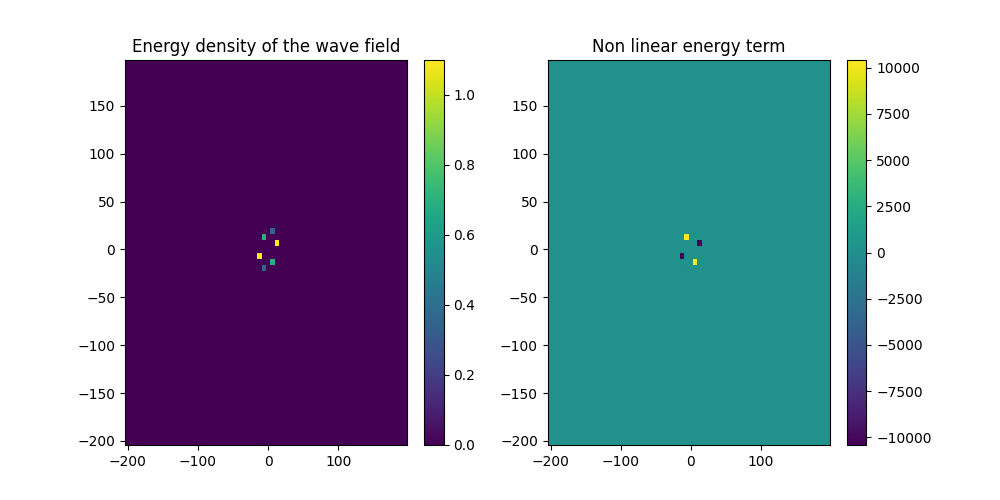

The sum of the linear energy term is:  767.8552224047522
The sum of the non linear energy term is:  (-3.188235567422212e-12+0j)
k1,k2,k3,k3+k1,k3+k2
-6.283185307179586 12.566370614359172 6.283185307179586 -18.84955592153876 0.0 18.84955592153876
l1,l2,l3,l3+l1,l3+l2
12.566370614359172 6.283185307179586 18.84955592153876 6.283185307179586 31.41592653589793 25.132741228718345


In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.pcolormesh(Kx,Ky,np.abs(fft))#energy_dens))
plt.title("Energy density of the wave field")
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolormesh(Kx,Ky,np.real(non_linear_energy))
plt.title("Non linear energy term")
plt.colorbar()
plt.show()

sum_lin=np.sum(energy_dens)
sum=np.sum(non_linear_energy)
print("The sum of the linear energy term is: ",sum_lin)
print("The sum of the non linear energy term is: ",sum)
print("k1,k2,k3,k3+k1,k3+k2")
print(k1,k2,k3,k1-k2,k3+k1,k3+k2)
print("l1,l2,l3,l3+l1,l3+l2")
print(l1,l2,l3,l1-l2,l3+l1,l3+l2)